# Iulian Hulea's fsimplified SHM workflow- add pore throats
# Drainage SHM directlly by fitting the Brooks-Corey parameters one by one
ideally one would refine the models after the first attempt
for the purpose of this exercise one iteration is sufficient 

#reservoir Fluid properties
sigmat&cosT=26 dy/cm (oil-water)
deltarho =0.43 (generic brine to oil density difference g/cm3)
#Lab Fluid properties for Hg-vacuum
sigmat&cos=367 dy/cm

# More details can be found under:
https://doi.org/10.2118/193164-MS
#Petrophysics: SPWLA-2016-v57n3a1

In [1]:
%pylab inline
%config InlineBackend.figure_format = "retina"
from scipy.optimize import curve_fit
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# defining some variables we use with some ranges
Nx = 100
xvalues = np.linspace(0.1, 100, Nx)
Np = 60
porc = np.linspace(0.01, 0.5, Np)
Rp = 501
PTR = 5 * np.logspace(2, -3, Rp)
PcIFT1 = 0.02 / PTR
# 1bar=10**(6)dy/cm**2 1b/dy/cm= 10^6/cm=100/ micrometer

In [3]:
# define some functions that will help us
def perm_function(POR, A, B):
    return 10 ** (A * log10(POR) + B)


def lin(x, A, B):
    return A * x + B


def swt(x, SWi, PCe, N):
    return np.minimum(1, np.maximum(0, SWi + (1 - SWi) * (PCe / x) ** (1.0 / N)))


def swix(x, POR, PERM, SWi, N):  # freeze the entry pressure to universal Pce
    return np.minimum(
        1,
        np.maximum(
            0,
            SWi
            + (1 - SWi) * ((0.12 * pow(np.sqrt(PERM / POR), -1.39)) / x) ** (1.0 / N),
        ),
    )


# FIT- this procedure fits the data according to a function of choice - Brooks-Corey in my case but it can be easilly replaced
def fitdf(
    fn, df
):  # this function requires data (dataframe - df) and a function to fit the data (fn)
    """
    df - expect data to have the following structure [uID, Sw, Pc_IFT1, perm, poro]
    fn - is function to be used in the fitting process
    """
    fit_p = []
    fit_p3 = []
    # Loop over unique sample ID
    for d in np.unique(df.uID):
        x = df.Sw[df.uID == d]  # saturation to be fitted
        y = df.Pc_IFT1[df.uID == d]  # Pc to be fitted- PCIFT1
        PERM = df.perm[df.uID == d]  # plug perm
        POR = df.poro[df.uID == d]  # plug por
        RT = np.unique(df.Rock[df.uID == d])
        res = curve_fit(
            fn,
            y,
            x,
            p0=[0.01, 0.11, 1.75],
            bounds=([0.0, 0.000001, 0.2], [0.25, 1000.0, 5.00]),
        )
        fit_p.append(res[0])  # collect the fit result
        fit_p3.append([np.average(POR), np.average(PERM), RT, d])
    fit_p = pd.DataFrame(
        fit_p, columns=["swi", "pce", "n"]
    )  # colect the fit result and plug properties in a dataframe
    fit_p3 = pd.DataFrame(fit_p3, columns=["por", "perm", "Rock", "uID"])
    # add the plug properties to the fit dataframe
    fit_p["por"] = fit_p3.por
    fit_p["perm"] = fit_p3.perm
    fit_p["Rock"] = fit_p3.Rock
    fit_p["uID"] = np.unique(df.uID)
    return fit_p

In [5]:
import pandas as pd

# load data and take care of units
df = pd.read_csv("SHM+RT_exercise.csv", sep=",", encoding="utf-8-sig", skiprows=[1])
df["Pc_IFT1"] = df.PC_PSI / 367 * 0.0689476  # convert from PSI to BAR and IFT1
df.rename(columns={"Permeability": "perm", "Porosity": "poro"}, inplace=True)
df["depth"] = df.ID
df["uID"] = (
    df.ID.map(str) + df.poro.map(str) + df.perm.map(str)
)  # create a unique ID to prevent issues addressing samples with the same properties
df.head()

wellName datasetName   ID    PC_PSI      perm      poro  \
0  Multiple wells_COMBINED       FINAL  1.0  0.145038  1245.824  0.238388   
1  Multiple wells_COMBINED       FINAL  1.0  0.261907  1245.824  0.238388   
2  Multiple wells_COMBINED       FINAL  1.0  0.472949  1245.824  0.238388   
3  Multiple wells_COMBINED       FINAL  1.0  0.854045  1245.824  0.238388   
4  Multiple wells_COMBINED       FINAL  1.0  1.542224  1245.824  0.238388   

   ReferenceName   Rock        Sw    WellName   Pc_IFT1  depth  \
0            4.0  PoorK  0.861136  Centrifuge  0.000027    1.0   
1            4.0  PoorK  0.741358  Centrifuge  0.000049    1.0   
2            4.0  PoorK  0.606260  Centrifuge  0.000089    1.0   
3            4.0  PoorK  0.469318  Centrifuge  0.000160    1.0   
4            4.0  PoorK  0.332578  Centrifuge  0.000290    1.0   

                                        uID  
0  1.00.238388000000000021245.8239999999998  
1  1.00.238388000000000021245.8239999999998  
2  1.00.238388000000000021245.8239999999998  
3  1.00.238388000000000021245.8239999999998  
4  1.00.238388000000000021245.8239999999998

In [6]:
# clean the data investigate what does it look like
# eliminate if no porosity available
df = df[(~np.isnan(df.poro))]
print(np.unique(df.WellName))  # print wellname (data type in this cvase)
print(np.unique(df.ID))
print(len(np.unique(df.uID)))
df = df.dropna(how="all")
# isolate the CF dataset
dfc = df[(df.WellName == "Centrifuge") & (df.Sw < 1) & (df.Sw > 0) & (df.poro > 0.01)]
dfc["Pc_IFT1"] = dfc.PC_PSI / 26 * 0.0689476
# isolate the MICP and a limited Sw range, minimum porosity
df = df[(df.WellName == "MICP") & (df.Sw < 1) & (df.Sw > 0) & (df.poro > 0.01)]
# Set the maximum Pc to be fitted - corresponding to max attainable reservoir Pc
df1 = df[df.Pc_IFT1 < 1.21]

['Centrifuge' 'MICP']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90.
 91. 92. 93. 94. 95. 96. 97.]
97


C:\Apps\Utils\conda\envs\geoml2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


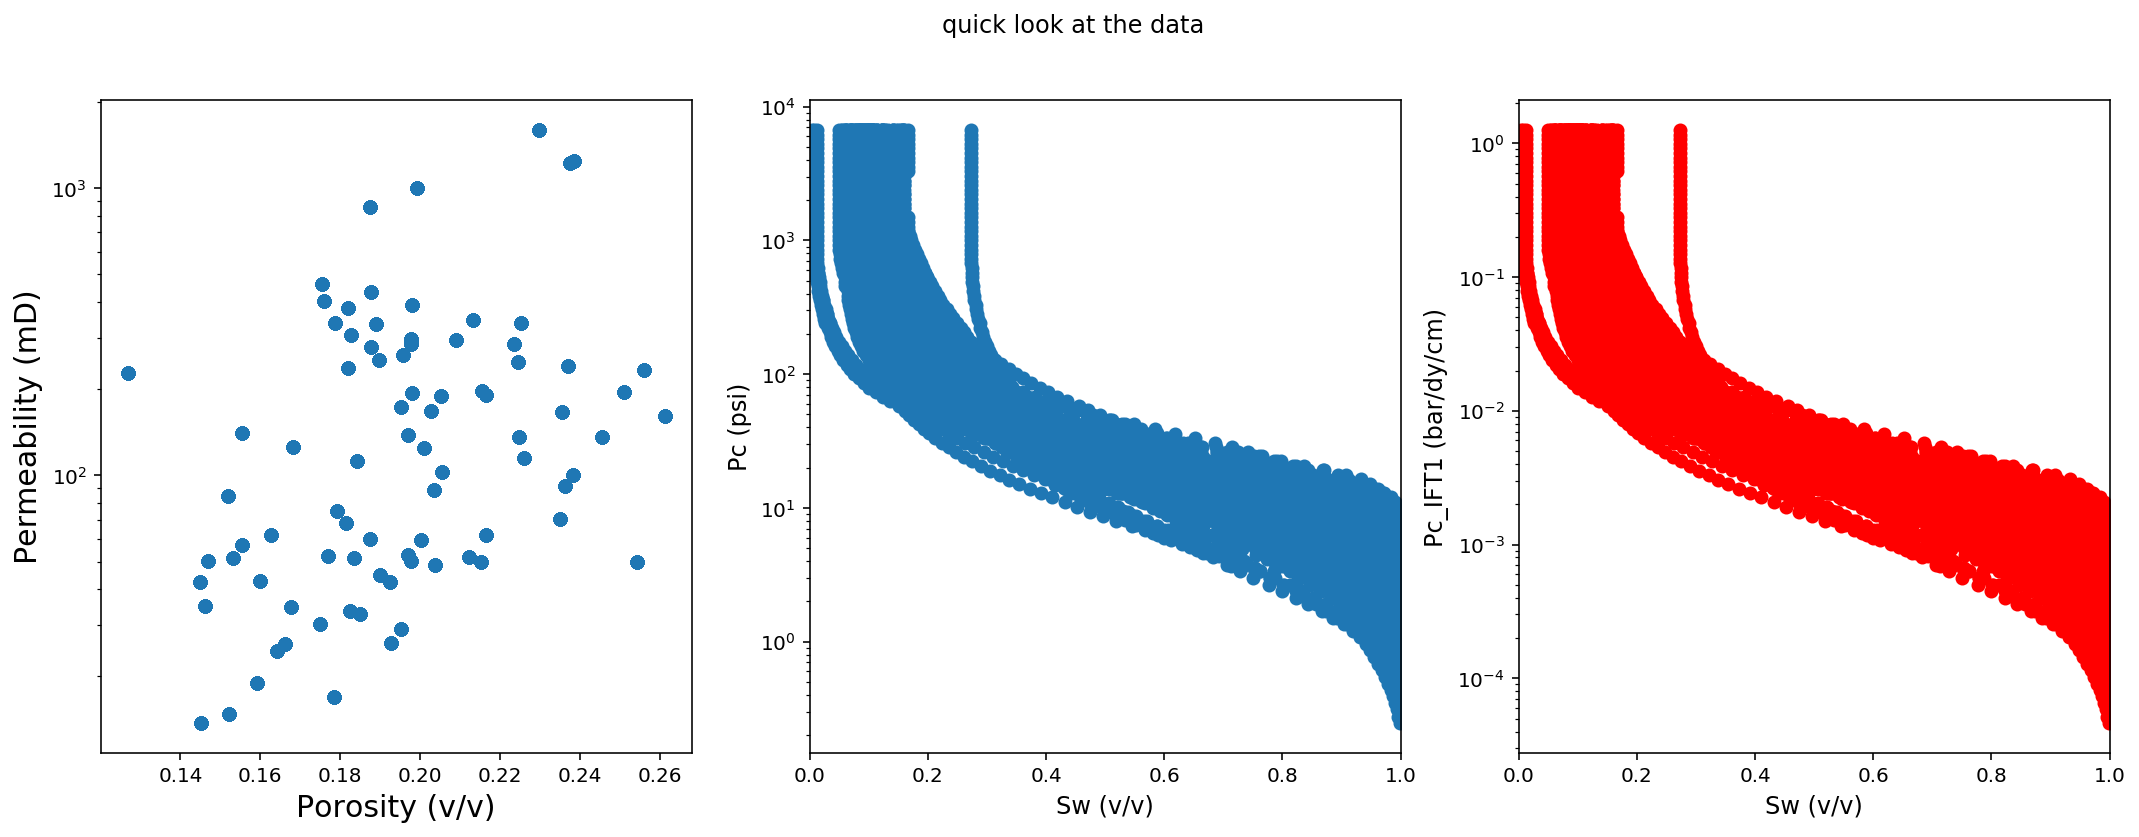

In [7]:
# Quick look at the data to be modelled
plt.subplot(1, 3, 1)
plt.semilogy(df.poro, df.perm, "o")
plt.xlabel("Porosity (v/v)", size=15)
plt.ylabel("Permeability (mD)", size=15)
plt.subplot(1, 3, 2)
plt.semilogy(df.Sw, df.PC_PSI, "o")
plt.xlim(0, 1)
plt.xlabel("Sw (v/v)", size=12)
plt.ylabel("Pc (psi)", size=12)

plt.subplot(1, 3, 3)
plt.semilogy(df.Sw, df.Pc_IFT1, "o", color="r")
plt.xlim(0, 1)
plt.xlabel("Sw (v/v)", size=12)
plt.ylabel("Pc_IFT1 (bar/dy/cm)", size=12)
plt.suptitle("quick look at the data")
plt.gcf().set_size_inches(18, 6)

In [8]:
# call the function to carry out fitting
fit_p = fitdf(swt, df1)  # fit the df1 data according to the swt function
# have a quick look at the fit result data structure
fit_p.head()

swi       pce         n       por       perm       Rock  \
0  7.206616e-02  0.001008  1.545052  0.196859   137.5550  [RT_test]   
1  5.624361e-02  0.000679  1.838157  0.195659   262.9507    [PoorK]   
2  4.188030e-21  0.000332  2.603933  0.199254   998.5618    [PoorK]   
3  3.769727e-02  0.000362  2.032040  0.238388  1245.8240    [PoorK]   
4  3.247790e-02  0.001145  1.539444  0.251008   194.9314  [RT_test]   

                                         uID  
0             14.00.19685899999999998137.555  
1                       15.00.195659262.9507  
2                       16.00.199254998.5618  
3  17.00.238388000000000021245.8239999999998  
4                       18.00.251008194.9314

Text(0.5, 0.98, 'plot the fit result vs permeability/porosity')

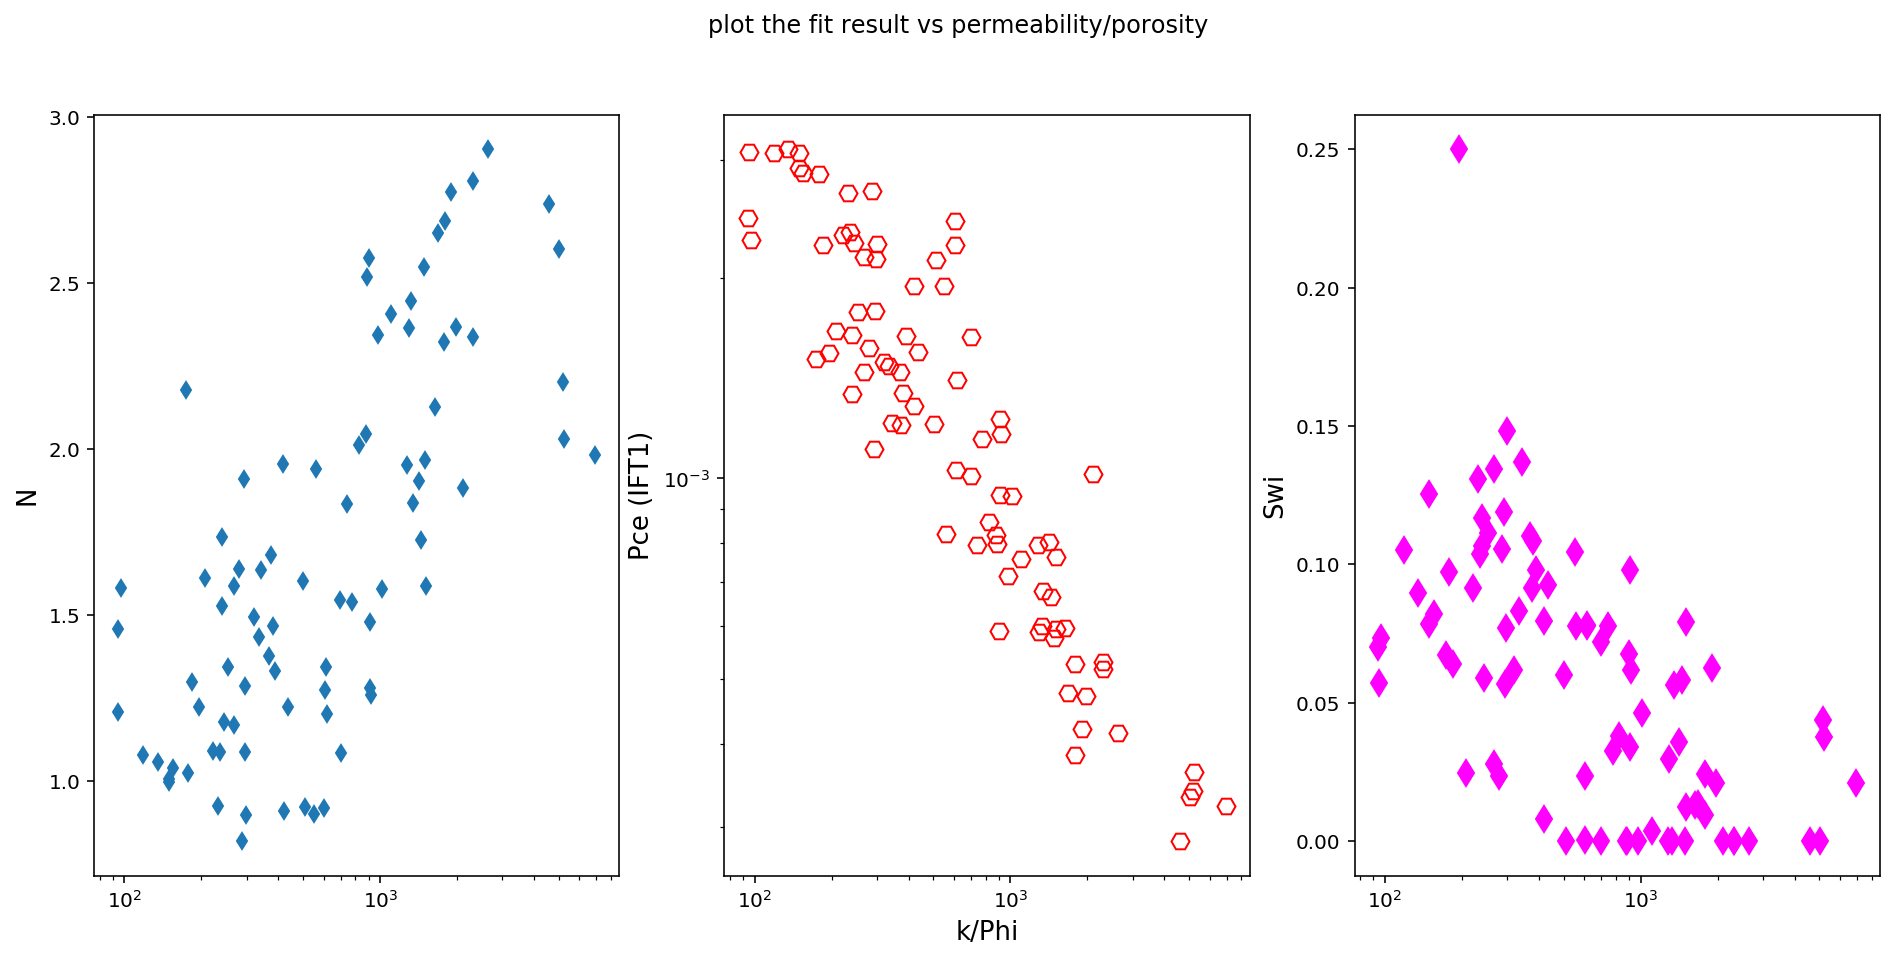

In [9]:
# investidate the fit result
plt.subplot(131)

plt.semilogx(fit_p.perm / fit_p.por, fit_p.n, "d")
plt.ylabel("N", size=13)
plt.subplot(132)
# plt.semilogx(fit_p2.perm/fit_p2.por,(0.12 * pow(sqrt(fit_p2.perm / fit_p2.por), -1.39)), "o", color= "green")
plt.loglog(fit_p.perm / fit_p.por, fit_p.pce, "H", ms=9, fillstyle="none", color="r")
plt.xlabel("k/Phi", size=13)
plt.ylabel("Pce (IFT1)", size=13)
plt.subplot(133)
plt.ylabel("Swi", size=13)
# plt.semilogx(fit_p2.perm/fit_p2.por,fit_p2.swi, "o", color= "green")
plt.semilogx(fit_p.perm / fit_p.por, fit_p.swi, "d", ms=9, color="magenta")


plt.gcf().set_size_inches(16, 7)
plt.suptitle("plot the fit result vs permeability/porosity")

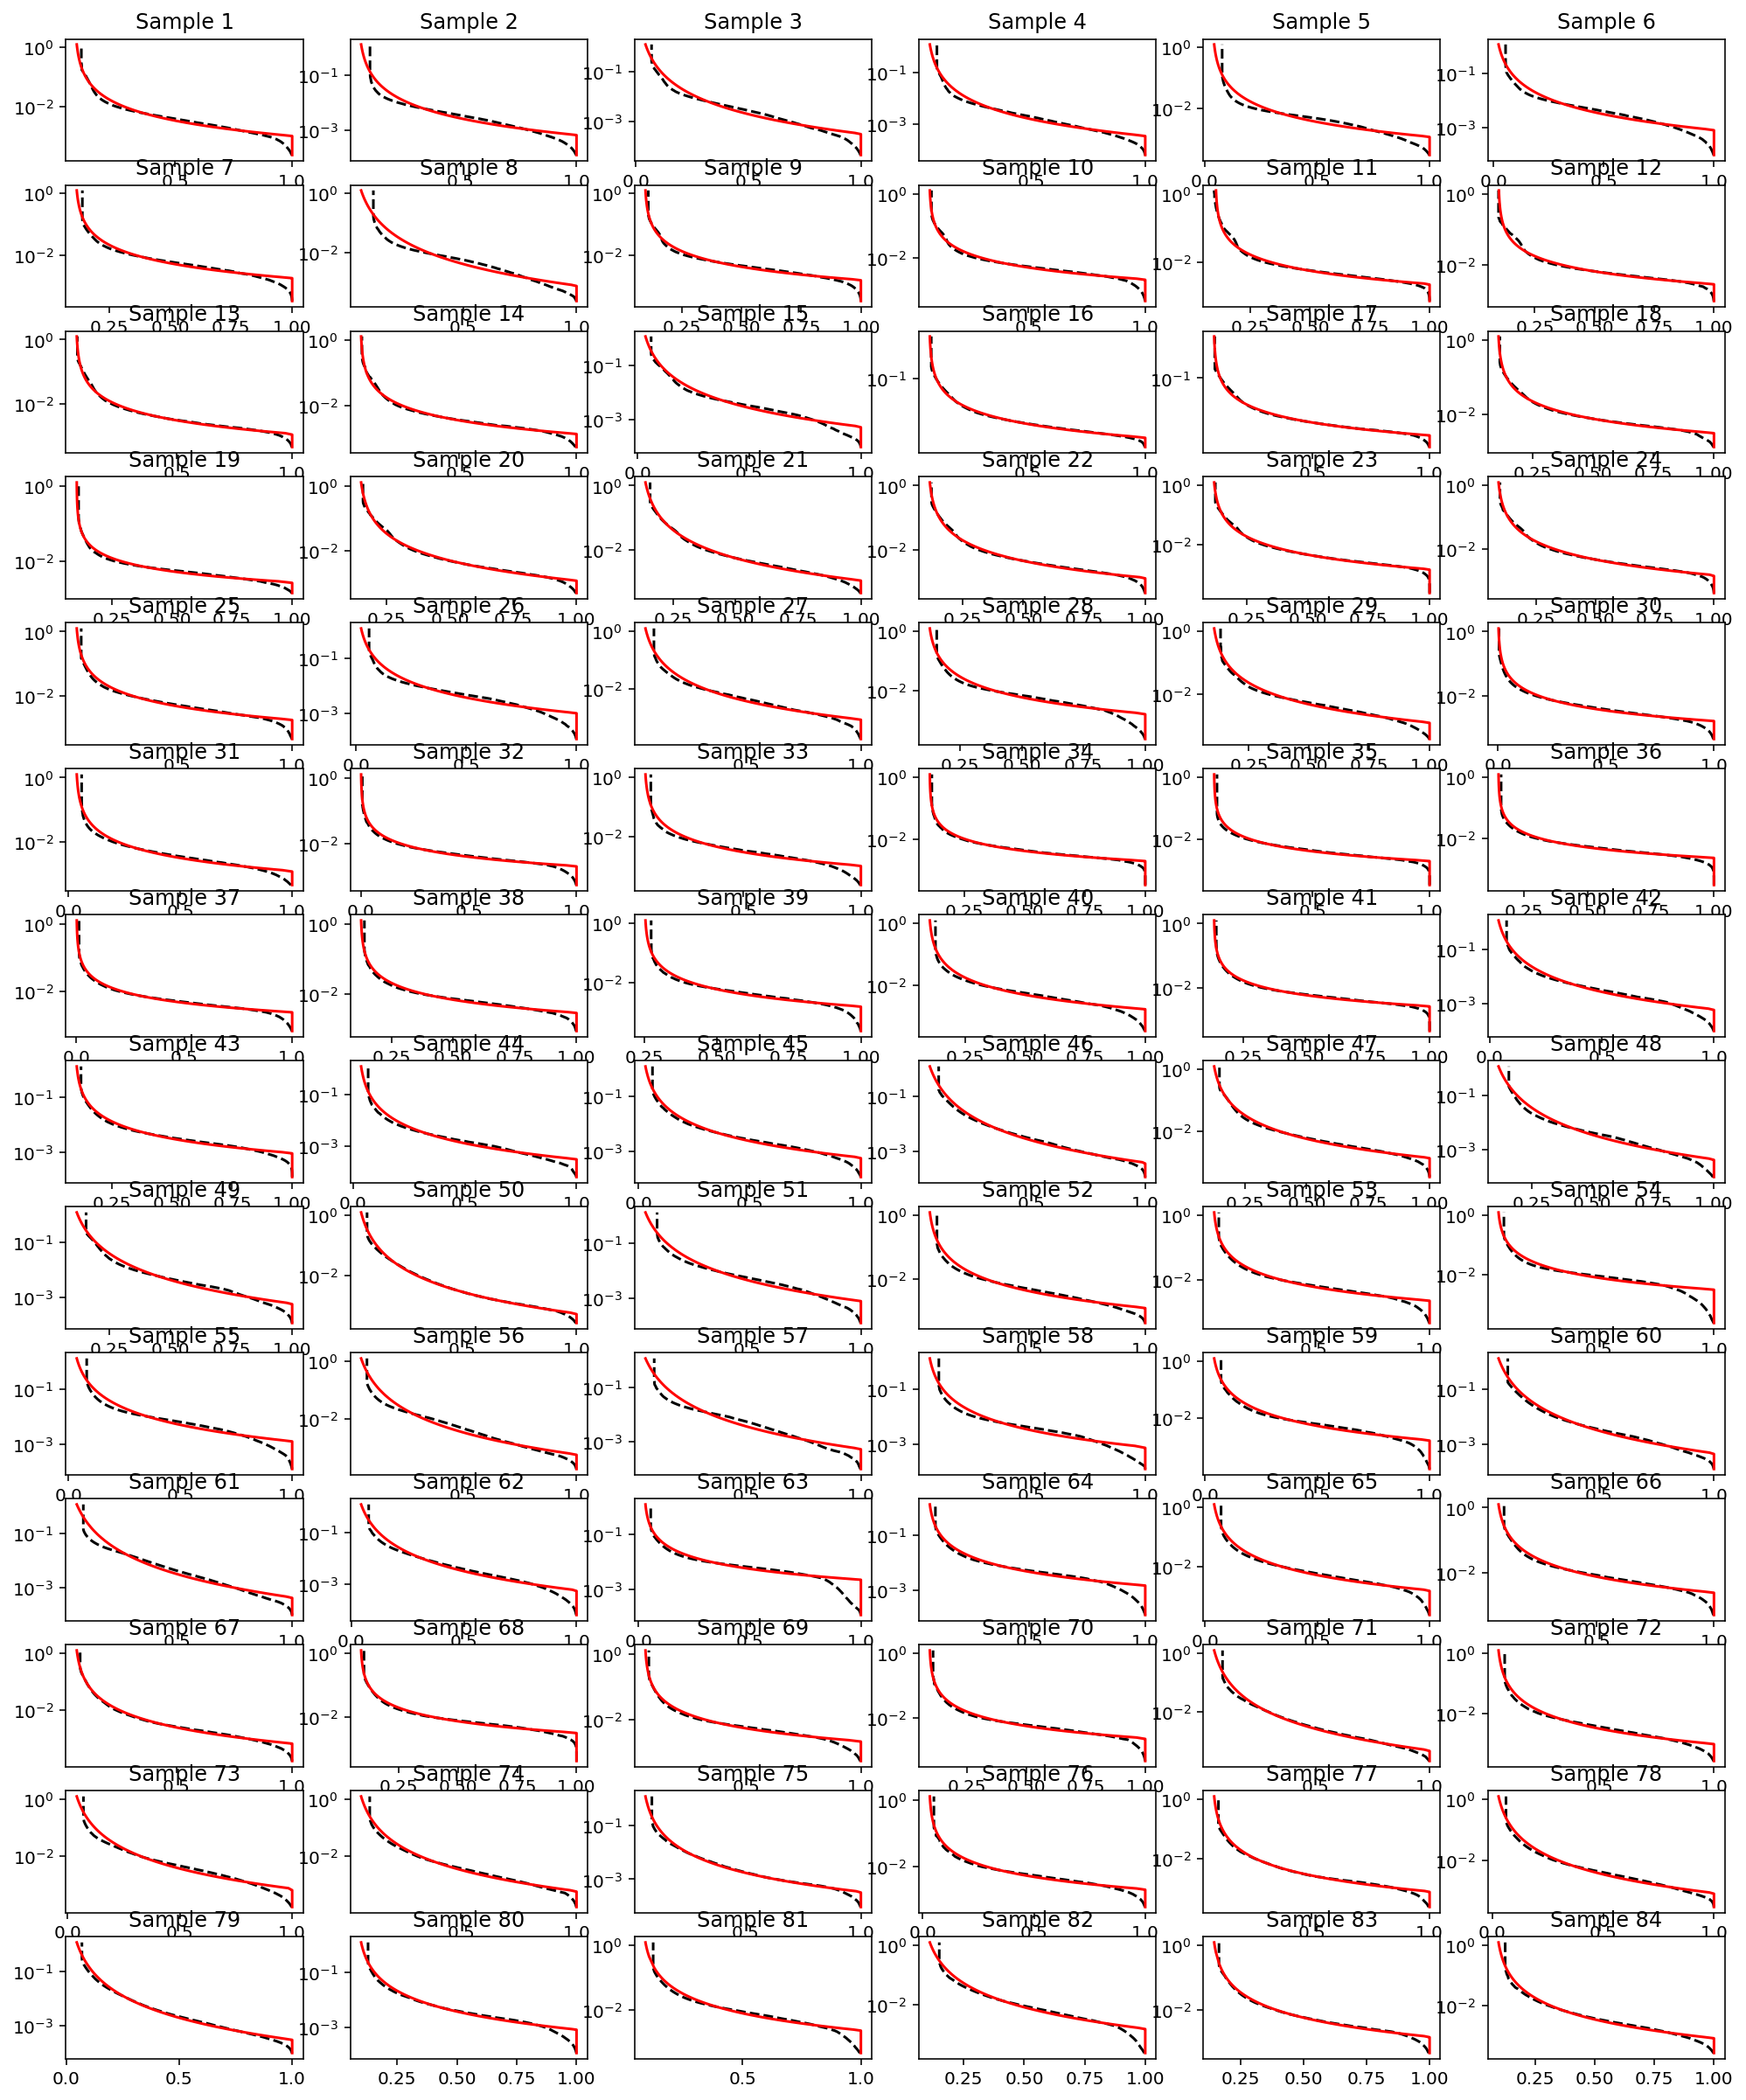

In [10]:
# check fit vs input per sample
brazil = df
for i, d in enumerate(unique(brazil.depth)):
    x = brazil.Sw[brazil.depth == d]  #
    y = brazil.Pc_IFT1[brazil.depth == d]

    plt.subplot(int(len(unique(brazil.depth)) / 4), 6, 1 + i)
    plt.title("Sample %d" % (i + 1))
    plt.plot(x, y, "--", color="black")
    plt.semilogy(swt(y, fit_p.swi[i], fit_p.pce[i], fit_p.n[i]), y, color="r")
    # plt.semilogy(swix(y,fit_p.por[i],fit_p.perm[i],fit_p.swi[i],fit_p.n[i]),y,color= "green")
plt.gcf().set_size_inches(17, 32)

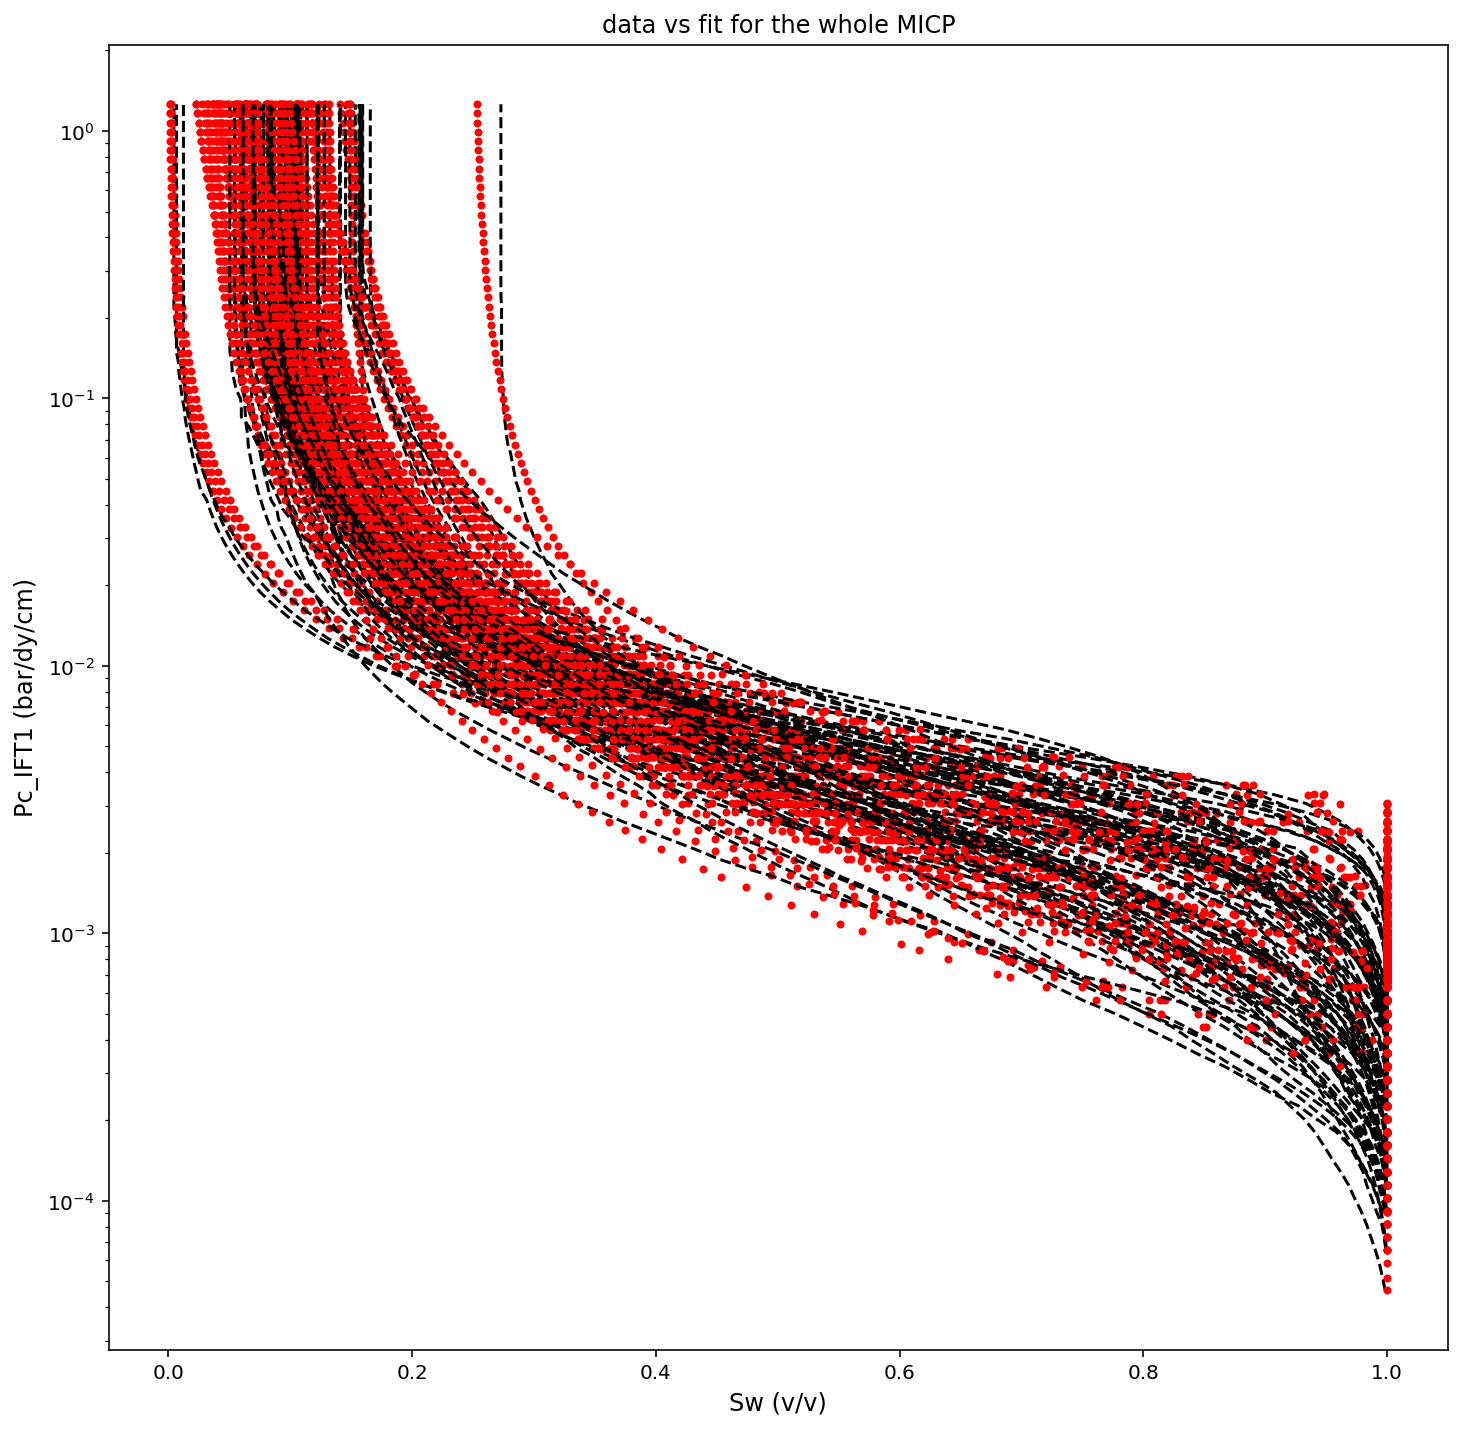

In [11]:
for i, d in enumerate(unique(brazil.depth)):
    y = brazil.Pc_IFT1[brazil.depth == d]
    plt.plot(
        brazil.Sw[brazil.depth == d],
        brazil.Pc_IFT1[brazil.depth == d],
        "--",
        color="black",
    )
    plt.semilogy(swt(y, fit_p.swi[i], fit_p.pce[i], fit_p.n[i]), y, ".", color="red")
plt.title("data vs fit for the whole MICP")
plt.xlabel("Sw (v/v)", size=12)
plt.ylabel("Pc_IFT1 (bar/dy/cm)", size=12)
plt.gcf().set_size_inches(12, 12)

# MODEL individual Brooks-Corey parameters so they can be predicted based on a combination of Porosity&Permeability

Text(0.5, 0.98, 'as an example we look for an N/Swi correlation vs Porosity as well')

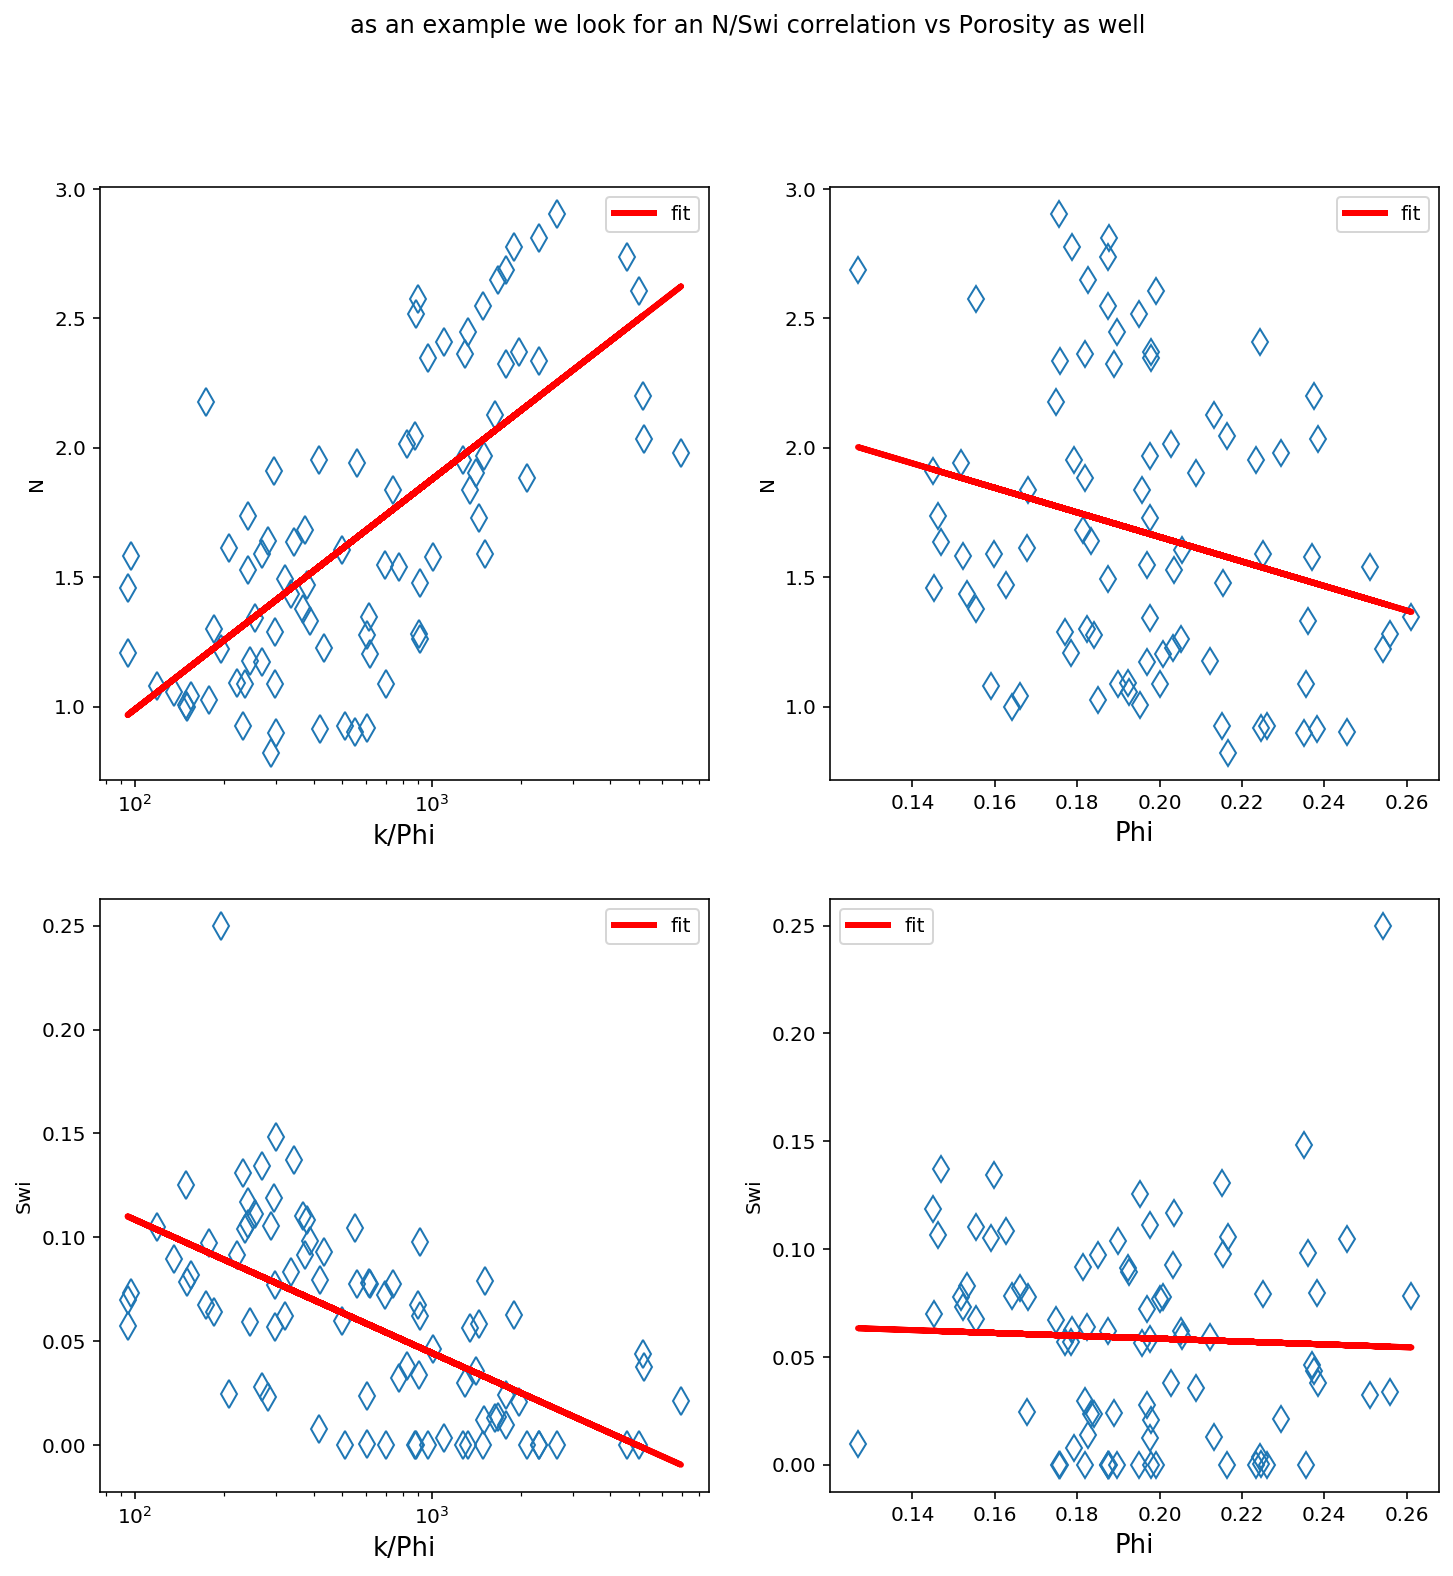

In [12]:
# fit the individual Pce, N and Swi dependency
# 1.Pce
y = np.log10(fit_p.pce)
y1 = fit_p.n
si = fit_p.swi
x = np.log10(fit_p.perm / fit_p.por)
lin_bsr = curve_fit(lin, x, y)
# 2. N

lin_n = curve_fit(lin, x, y1)  # fit N vs k/phi
lin_n_por = curve_fit(lin, fit_p.por, y1)  # fit n vs Por
# 2. Swi

lin_swi_por = curve_fit(lin, fit_p.por, fit_p.swi)  # fit n vs Por
lin_swi = curve_fit(lin, x, fit_p.swi)  # fit n vs Por

plt.subplot(221)
xx = fit_p.perm / fit_p.por
plt.semilogx(fit_p.perm / fit_p.por, fit_p.n, "d", ms=10, fillstyle="none")
plt.plot(
    fit_p.perm / fit_p.por,
    lin(np.log10(xx), lin_n[0][0], lin_n[0][1]),
    "-",
    lw=3,
    color="r",
    label="fit",
)
plt.legend()
plt.ylabel("N")
plt.xlabel("k/Phi", size=13)

plt.subplot(222)
plt.plot(fit_p.por, fit_p.n, "d", ms=9, fillstyle="none")
plt.plot(
    fit_p.por,
    lin(fit_p.por, lin_n_por[0][0], lin_n_por[0][1]),
    "-",
    lw=3,
    color="r",
    label="fit",
)
plt.legend()
plt.ylabel("N")
plt.xlabel("Phi", size=13)

plt.subplot(223)
plt.semilogx(fit_p.perm / fit_p.por, fit_p.swi, "d", ms=10, fillstyle="none")
plt.plot(
    fit_p.perm / fit_p.por,
    lin(np.log10(xx), lin_swi[0][0], lin_swi[0][1]),
    "-",
    lw=3,
    color="r",
    label="fit",
)
plt.legend()
plt.ylabel("Swi")
plt.xlabel("k/Phi", size=13)

plt.subplot(224)
plt.plot(fit_p.por, fit_p.swi, "d", ms=9, fillstyle="none")
plt.plot(
    fit_p.por,
    lin(fit_p.por, lin_swi_por[0][0], lin_swi_por[0][1]),
    "-",
    lw=3,
    color="r",
    label="fit",
)
plt.legend()
plt.ylabel("Swi")
plt.xlabel("Phi", size=13)


plt.gcf().set_size_inches(12, 12)

plt.suptitle("as an example we look for an N/Swi correlation vs Porosity as well")

Text(0.5, 0.98, 'red lines the model vs permeability/porosity (dots individual Pc fits)')

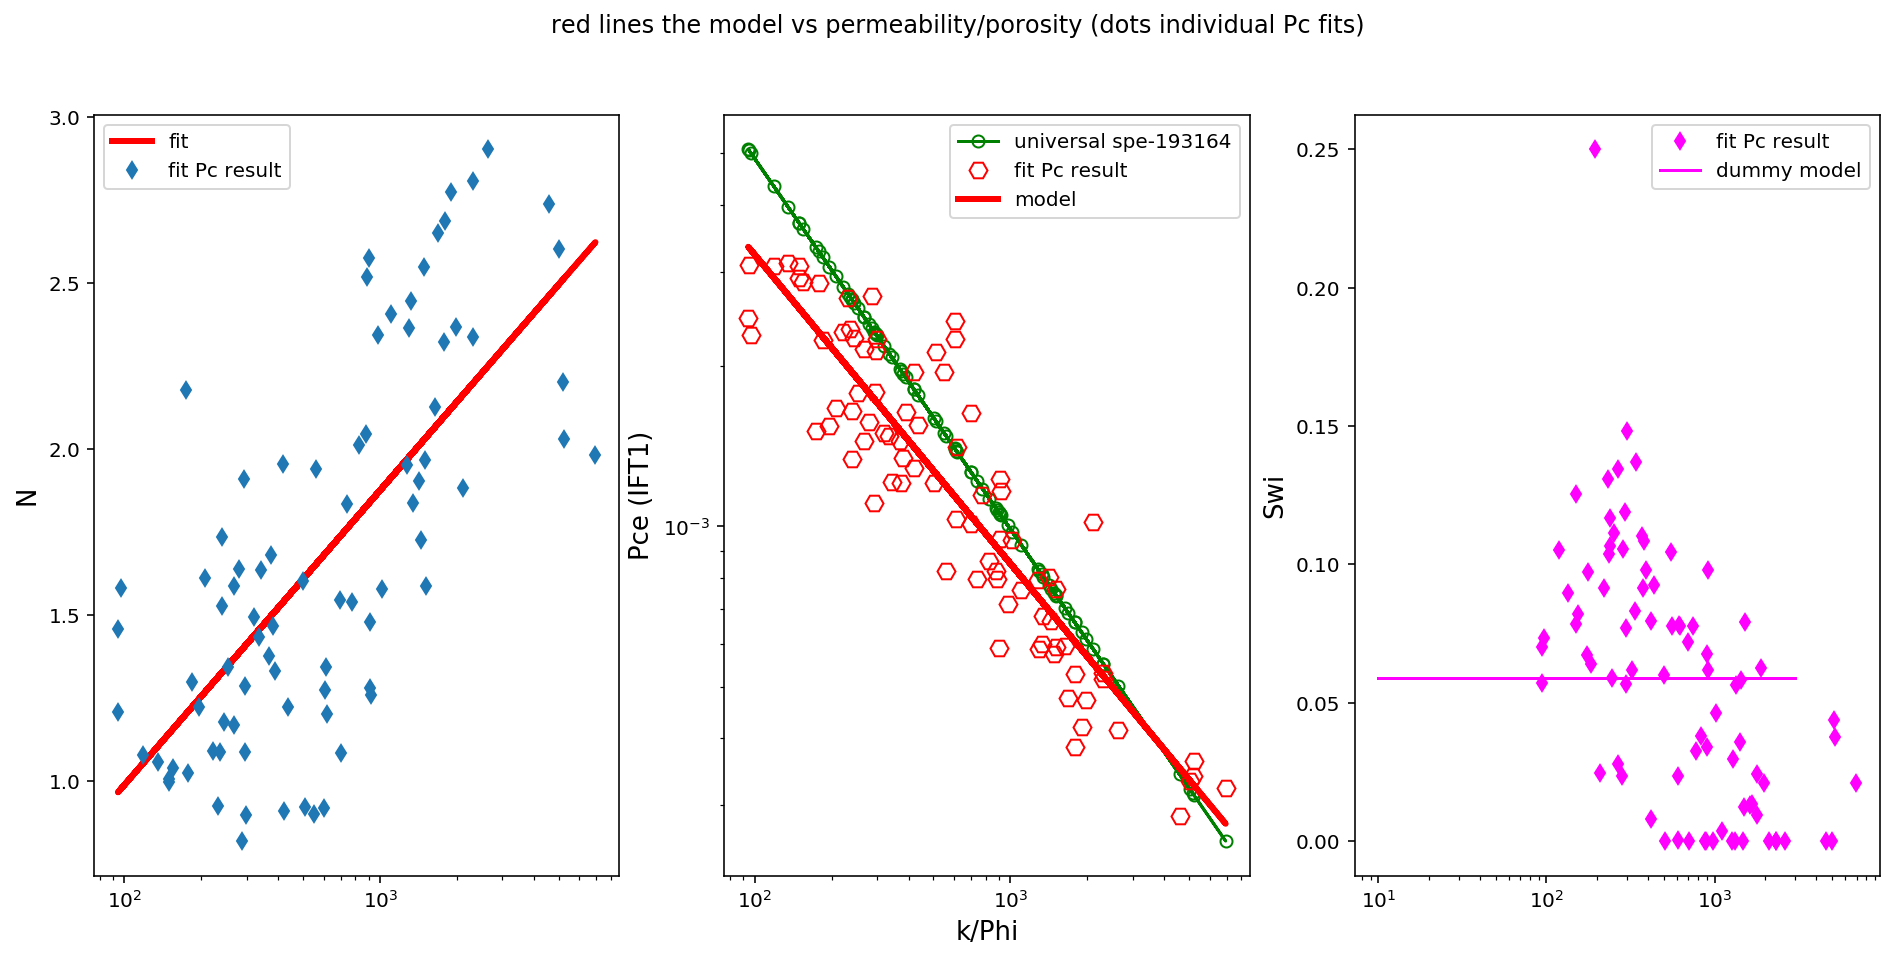

In [13]:
# investidate the fit result
plt.subplot(131)
plt.plot(
    fit_p.perm / fit_p.por,
    lin(np.log10(xx), lin_n[0][0], lin_n[0][1]),
    "-",
    lw=3,
    color="r",
    label="fit",
)
plt.semilogx(fit_p.perm / fit_p.por, fit_p.n, "d", label="fit Pc result")
plt.legend()
plt.ylabel("N", size=13)
plt.subplot(132)
plt.semilogx(
    fit_p.perm / fit_p.por,
    (0.12 * pow(sqrt(fit_p.perm / fit_p.por), -1.39)),
    "o-",
    fillstyle="none",
    color="green",
    label="universal spe-193164",
)
plt.loglog(
    fit_p.perm / fit_p.por,
    fit_p.pce,
    "H",
    ms=9,
    fillstyle="none",
    color="r",
    label="fit Pc result",
)
plt.plot(
    10 ** x,
    10 ** lin(x, lin_bsr[0][0], lin_bsr[0][1]),
    "-",
    lw=3,
    color="r",
    label="model",
)

plt.legend(loc="best")
# plt.loglog(fit_p.perm/fit_p.por,fit_p.pce, "H", ms=9, color="r", label ="fit result")
plt.xlabel("k/Phi", size=13)
plt.ylabel("Pce (IFT1)", size=13)
plt.subplot(133)
plt.ylabel("Swi", size=13)
# plt.semilogx(fit_p2.perm/fit_p2.por,fit_p2.swi, "o", color= "green")
plt.semilogx(
    fit_p.perm / fit_p.por, fit_p.swi, "d", color="magenta", label="fit Pc result"
)
plt.plot(
    (10, 3000),
    (np.mean(fit_p.swi), np.mean(fit_p.swi)),
    "-",
    color="MAGENTA",
    label="dummy model",
)
plt.legend()
plt.gcf().set_size_inches(16, 7)
plt.suptitle("red lines the model vs permeability/porosity (dots individual Pc fits)")

## Compare model vs data

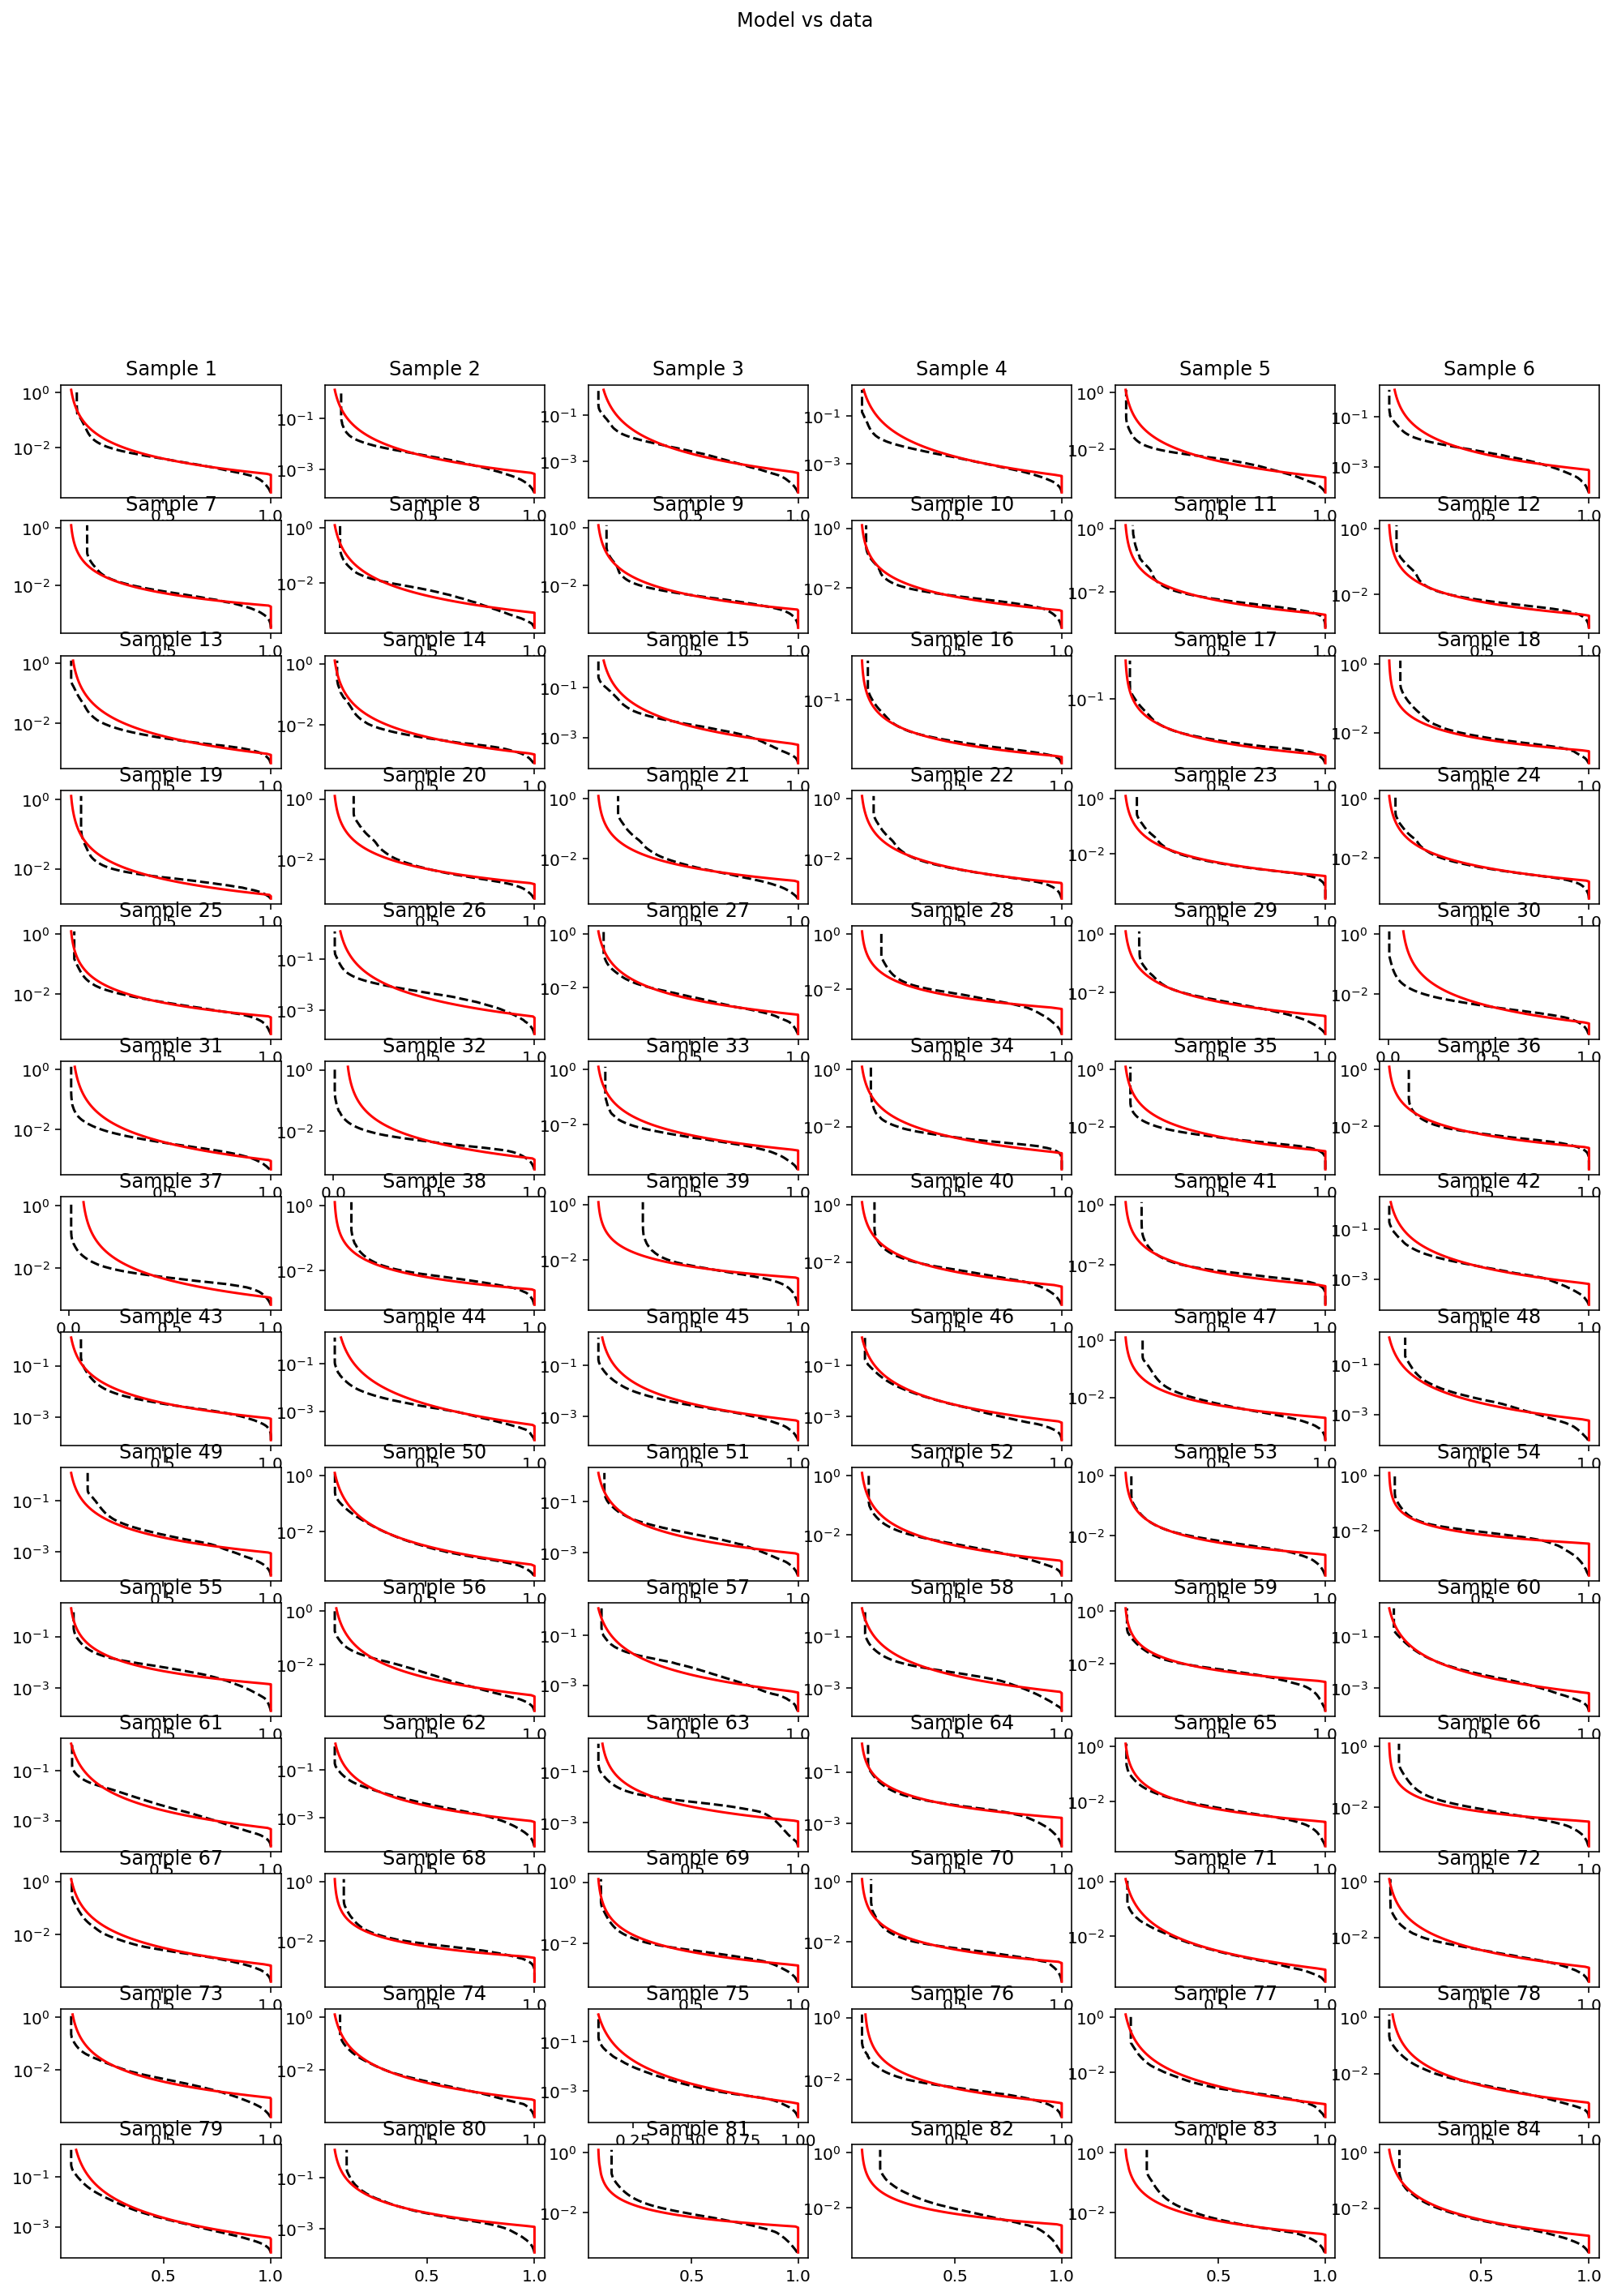

In [14]:
brazil = df
for i, d in enumerate(unique(brazil.depth)):
    x = brazil.Sw[brazil.depth == d]  #
    y = brazil.Pc_IFT1[brazil.depth == d]

    plt.subplot(int(len(unique(brazil.depth)) / 4), 6, 1 + i)
    plt.title("Sample %d" % (i + 1))
    plt.plot(x, y, "--", color="black")
    plt.semilogy(
        swt(
            y,
            np.mean(fit_p.swi),
            10
            ** lin(
                np.log10(fit_p.perm[i] / fit_p.por[i]), lin_bsr[0][0], lin_bsr[0][1]
            ),
            lin(np.log10((fit_p.perm[i] / fit_p.por[i])), lin_n[0][0], lin_n[0][1]),
        ),
        y,
        color="r",
    )
plt.suptitle("Model vs data")
plt.gcf().set_size_inches(17, 32)

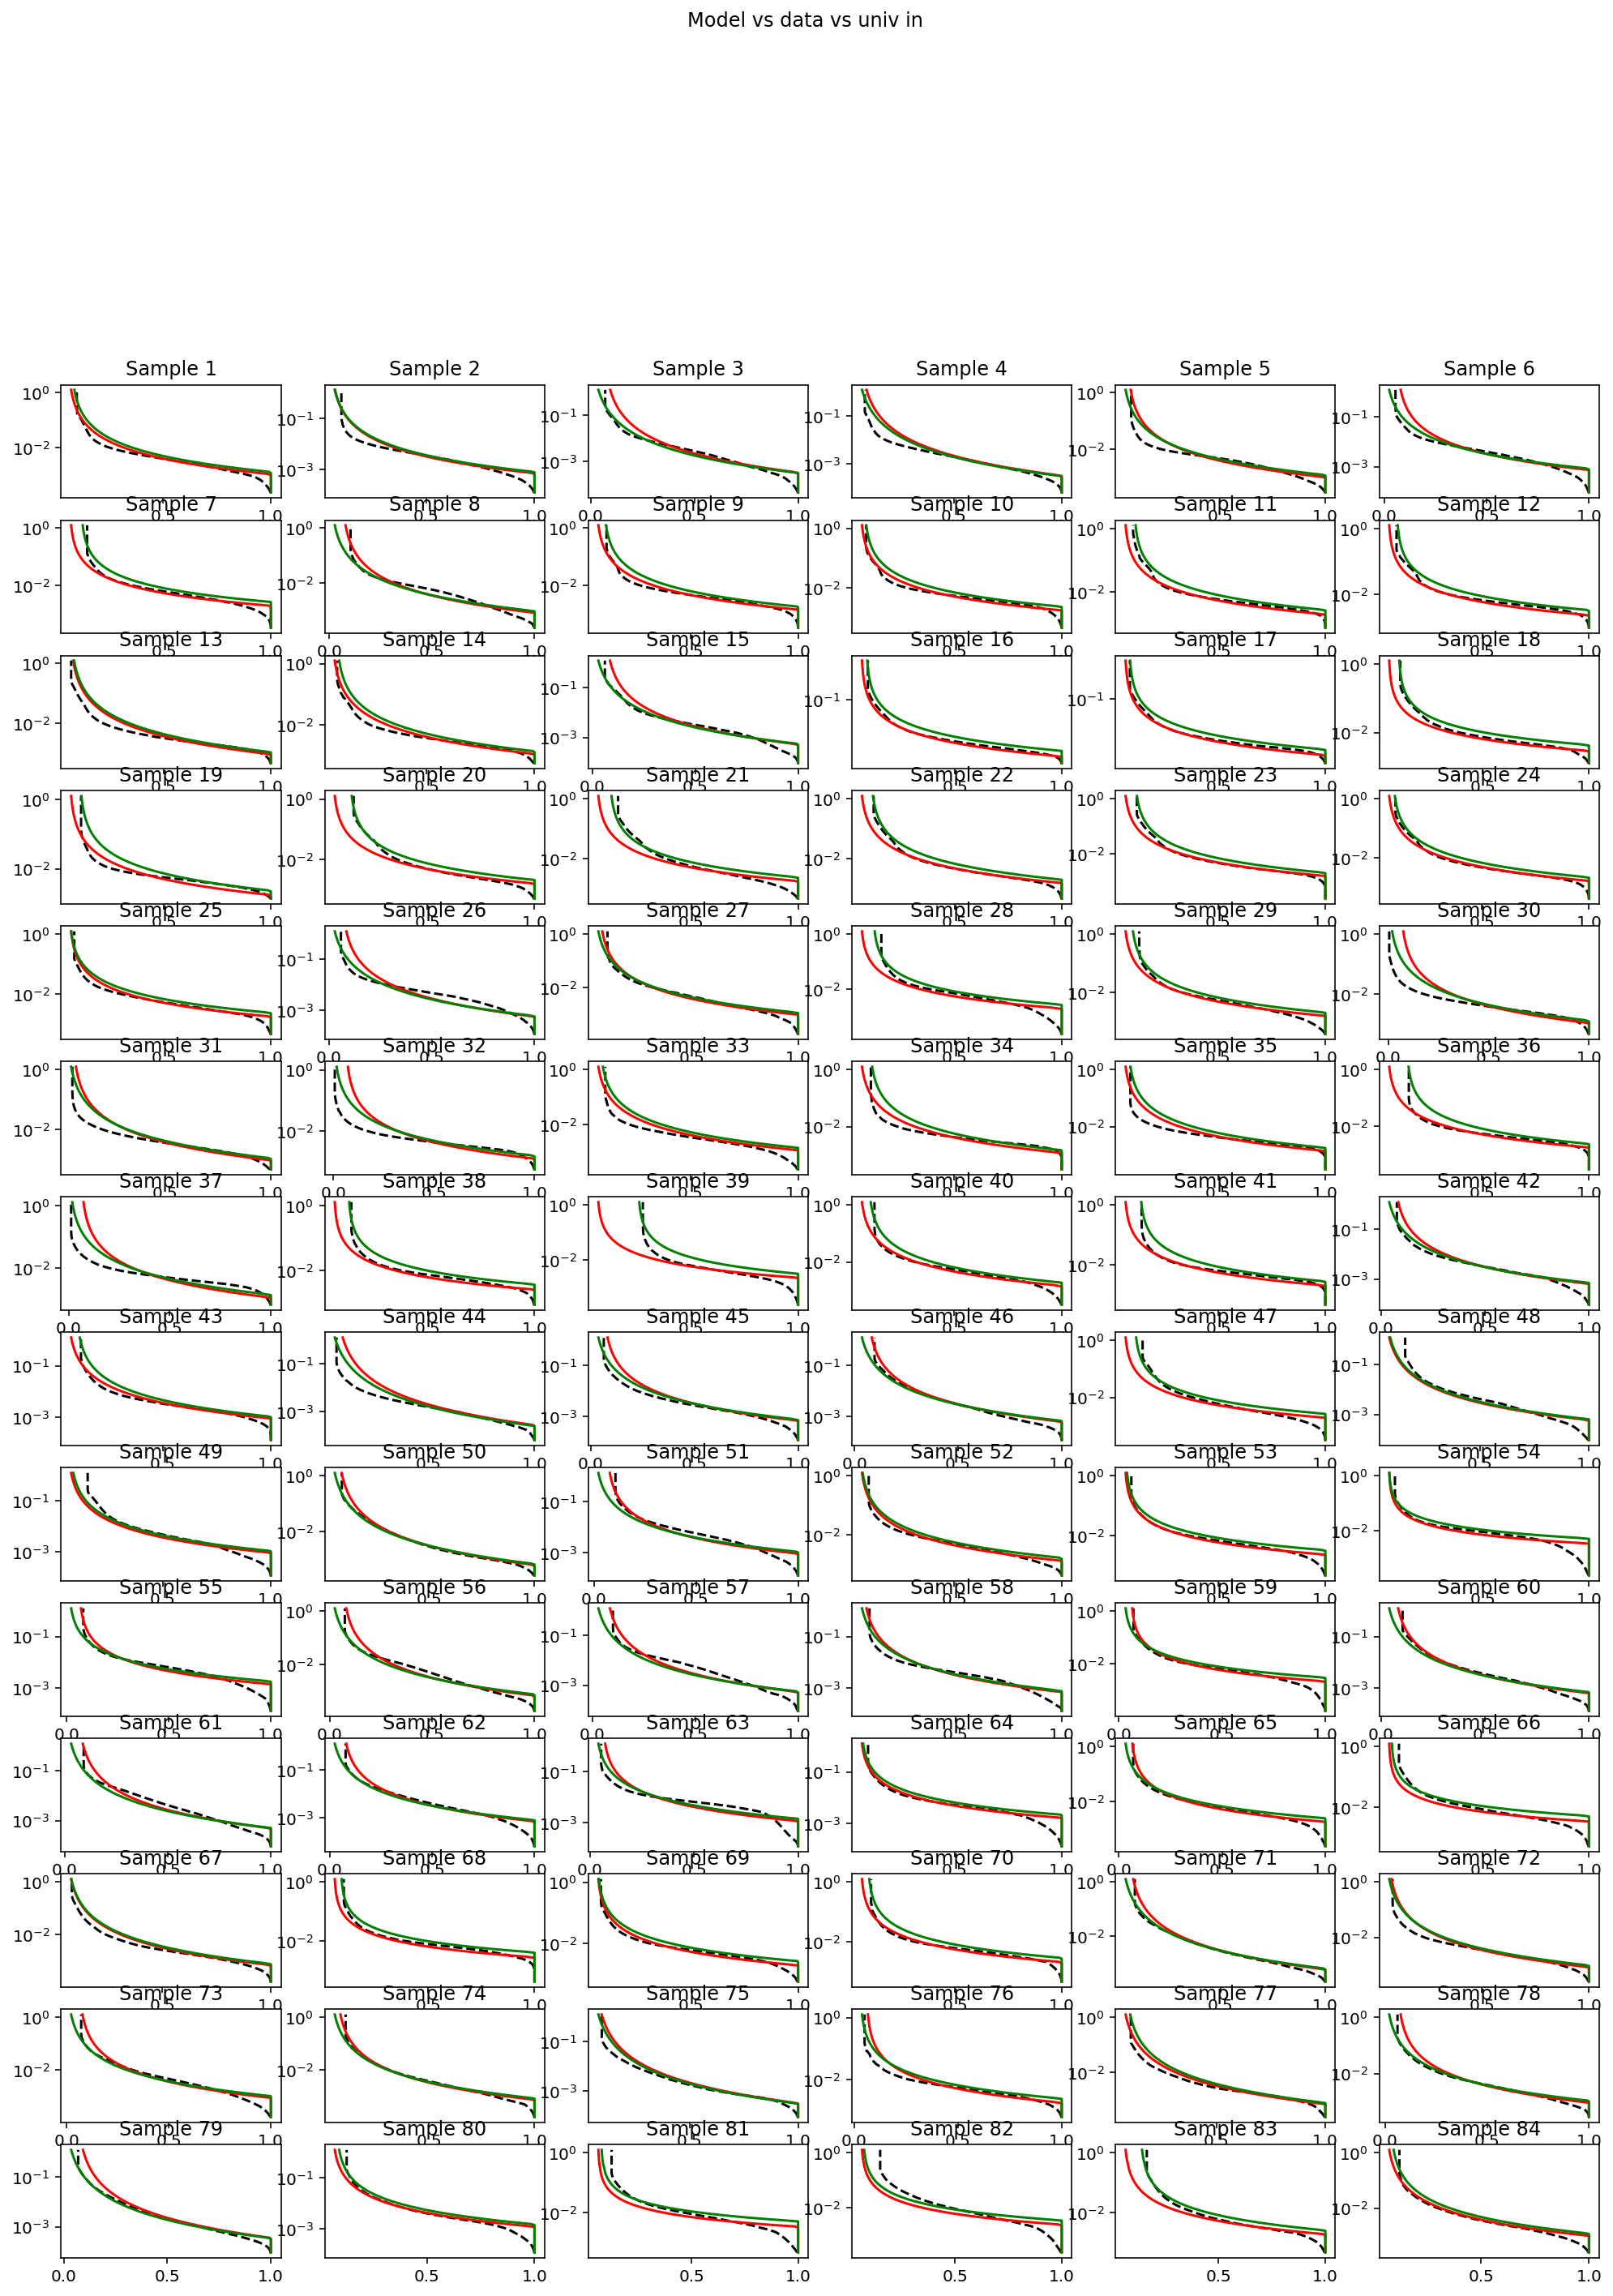

In [15]:
# Universal
brazil = df
for i, d in enumerate(unique(brazil.depth)):
    x = brazil.Sw[brazil.depth == d]  #
    y = brazil.Pc_IFT1[brazil.depth == d]

    plt.subplot(int(len(unique(brazil.depth)) / 4), 6, 1 + i)
    plt.title("Sample %d" % (i + 1))
    plt.plot(x, y, "--", color="black")
    plt.semilogy(
        swt(
            y,
            np.mean(fit_p.swi),
            10
            ** lin(
                np.log10(fit_p.perm[i] / fit_p.por[i]), lin_bsr[0][0], lin_bsr[0][1]
            ),
            lin(np.log10((fit_p.perm[i] / fit_p.por[i])), lin_n[0][0], lin_n[0][1]),
        ),
        y,
        color="r",
    )
    plt.semilogy(
        swix(
            y,
            fit_p.por[i],
            fit_p.perm[i],
            fit_p.swi[i],
            lin(np.log10((fit_p.perm[i] / fit_p.por[i])), lin_n[0][0], lin_n[0][1]),
        ),
        y,
        color="green",
    )
plt.suptitle("Model vs data vs univ in")
plt.gcf().set_size_inches(17, 32)

 # Blind test against CF subset

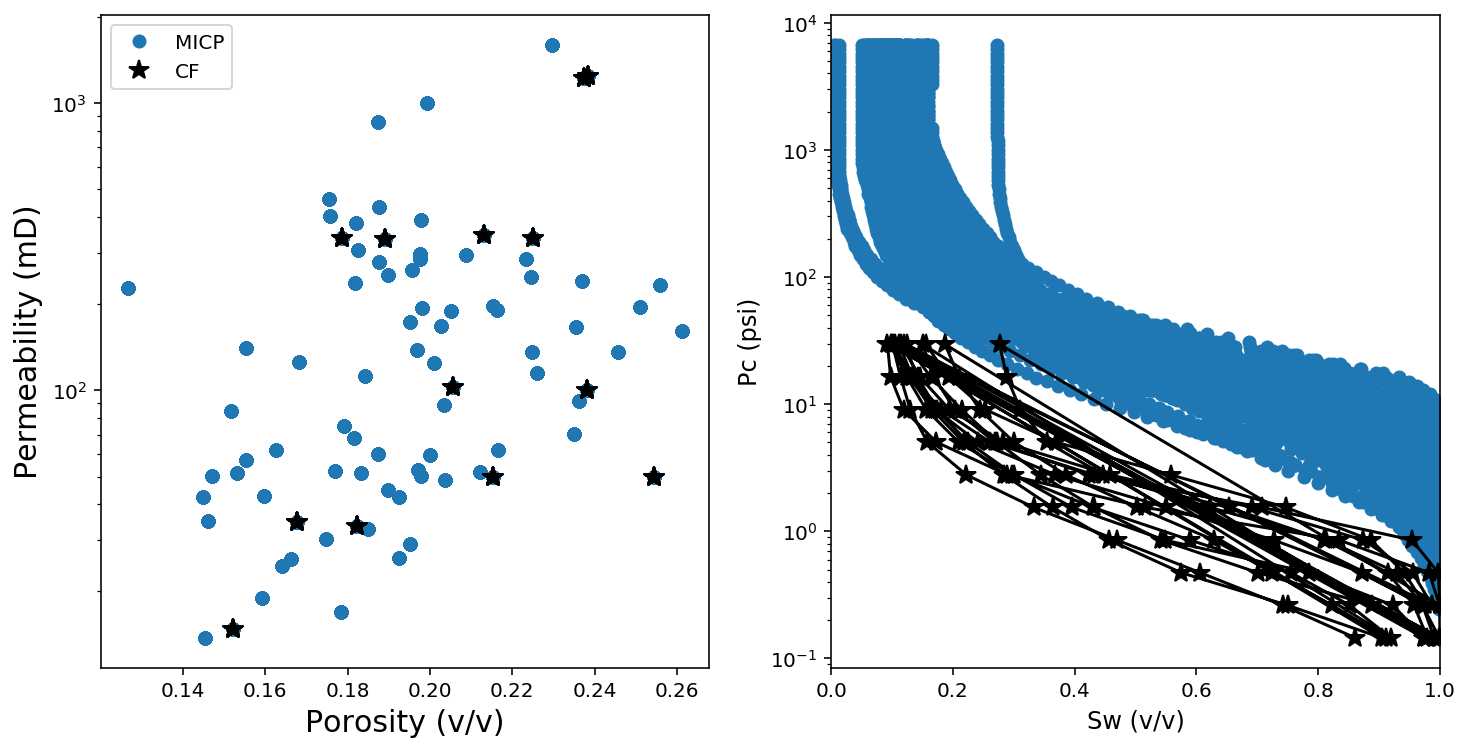

In [17]:
plt.subplot(1, 2, 1)
plt.semilogy(df.poro, df.perm, "o", label="MICP")
plt.semilogy(dfc.poro, dfc.perm, "*", ms=10, color="black", label="CF")
plt.legend(loc="best")
plt.xlabel("Porosity (v/v)", size=15)
plt.ylabel("Permeability (mD)", size=15)
plt.subplot(1, 2, 2)
plt.semilogy(df.Sw, df.PC_PSI, "o")
plt.semilogy(dfc.Sw, dfc.PC_PSI, "*-", ms=10, color="black")
plt.xlim(0, 1)
plt.xlabel("Sw (v/v)", size=12)
plt.ylabel("Pc (psi)", size=12)
plt.gcf().set_size_inches(12, 6)

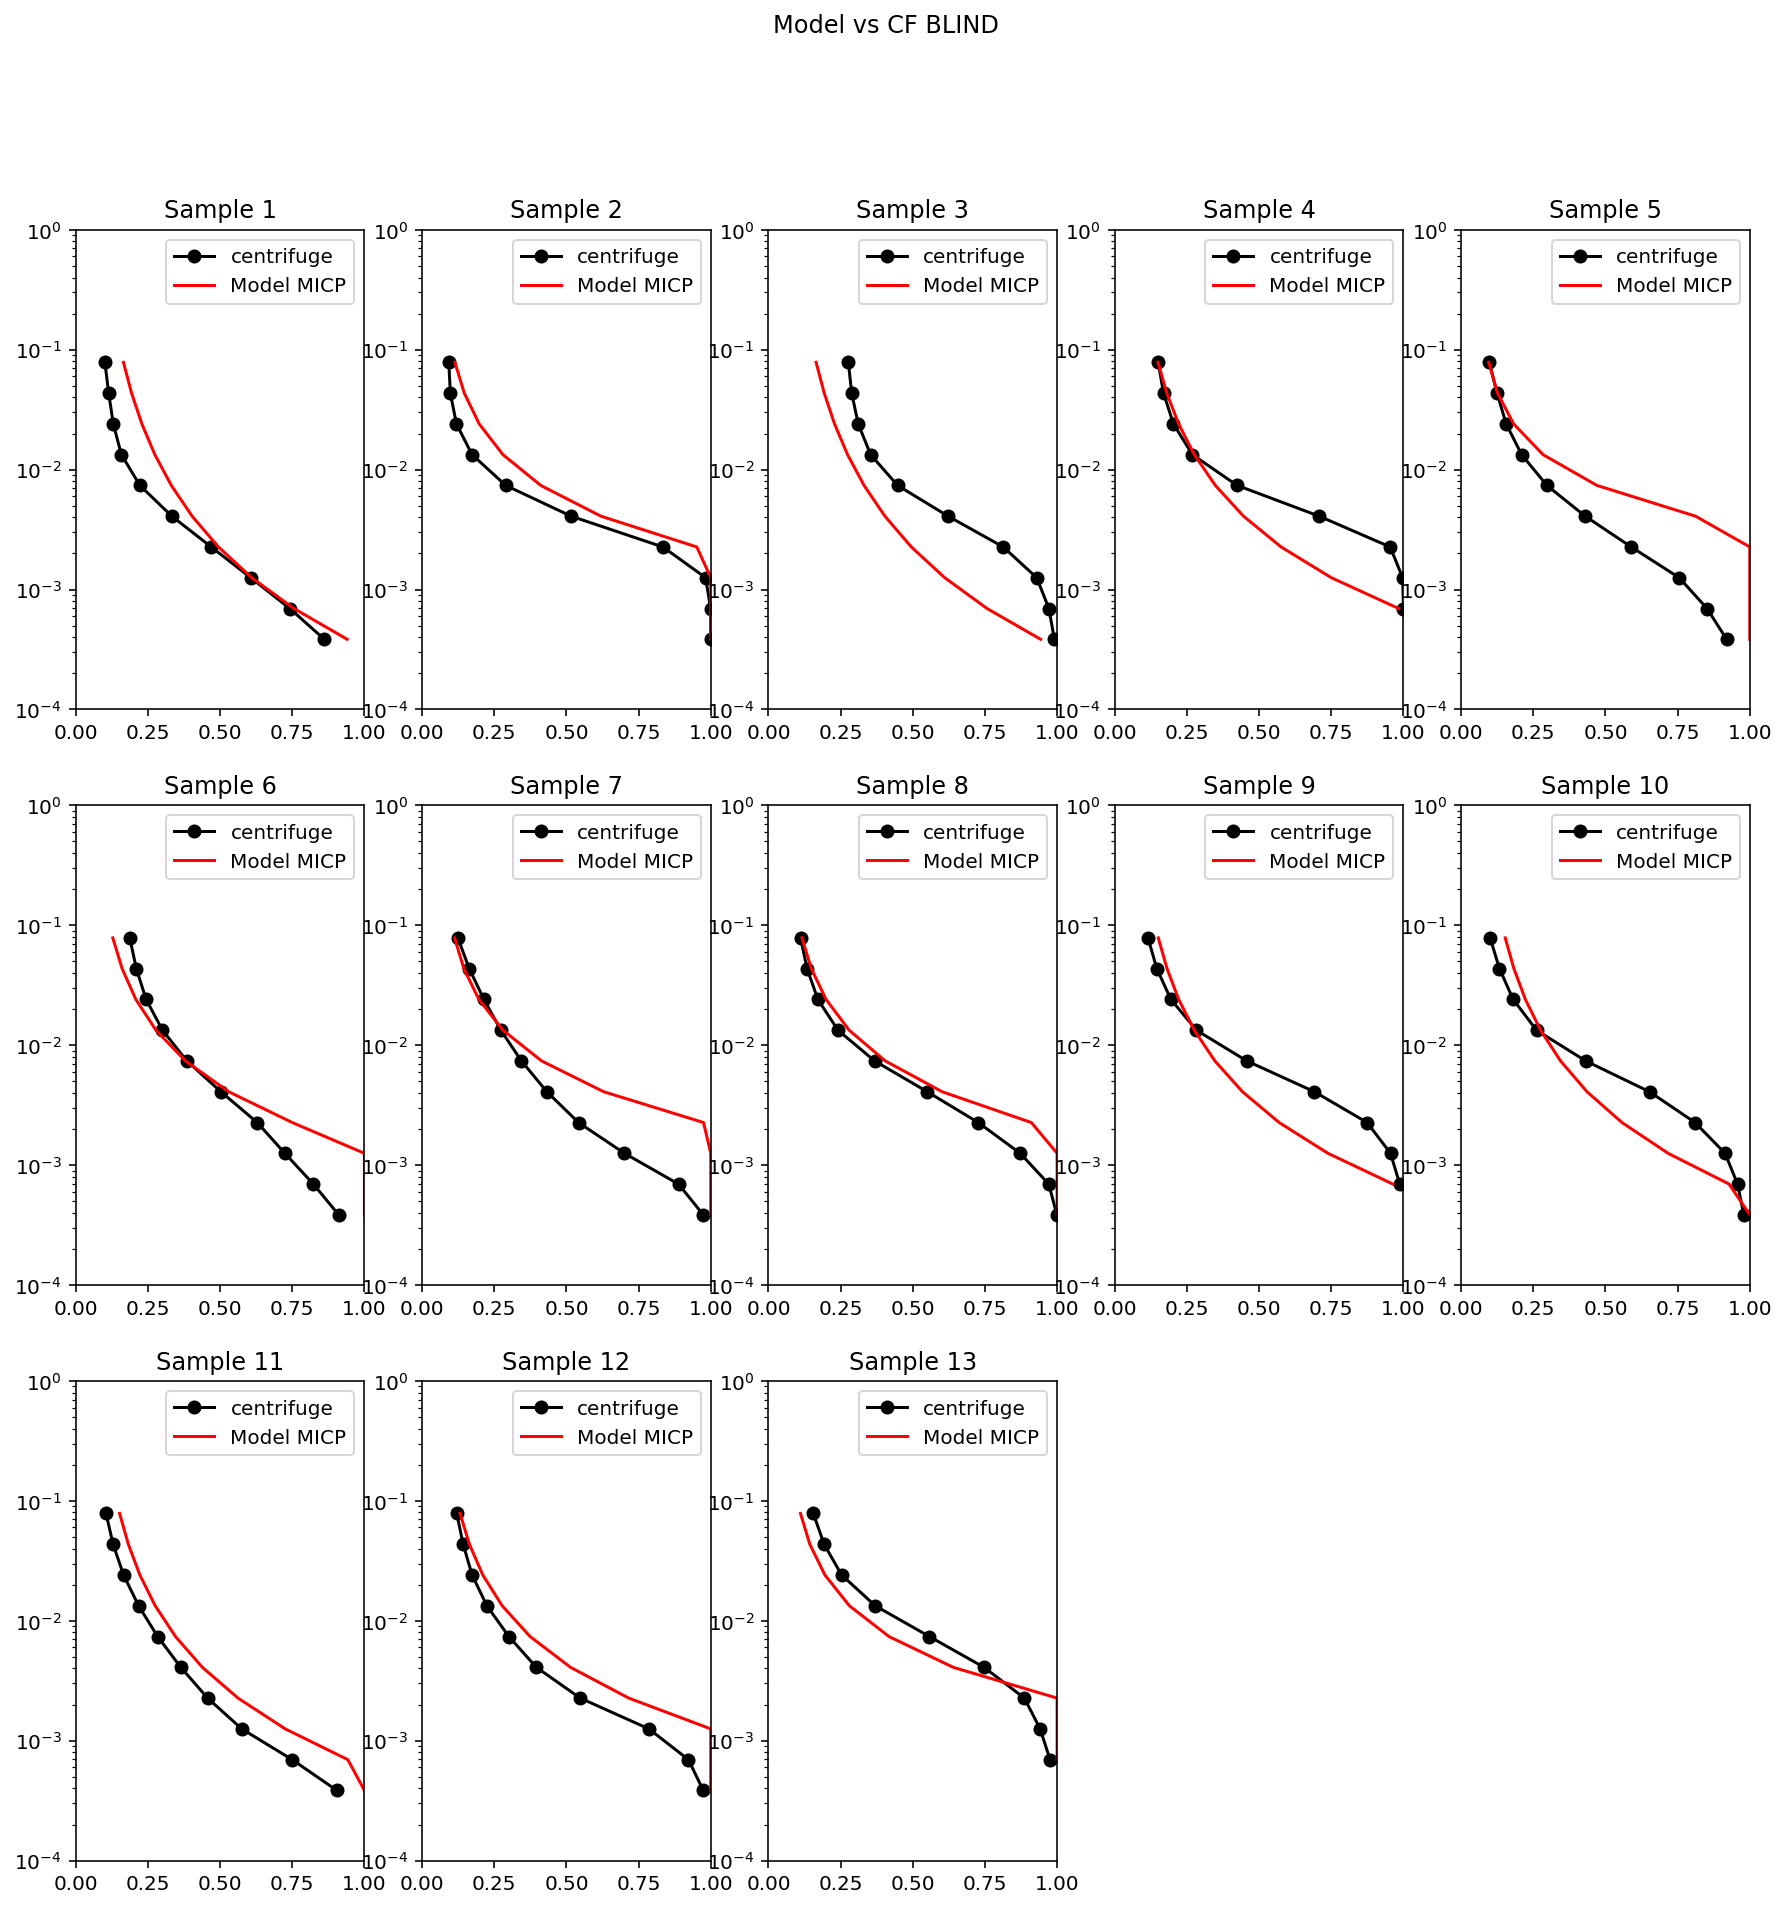

In [18]:
# We can build a new model on the Centrifuge data OR just compare against the prepared model
fit_pc = fitdf(swt, dfc)
brazil = dfc
for i, d in enumerate(unique(brazil.depth)):
    x = brazil.Sw[brazil.depth == d]  #
    y = brazil.Pc_IFT1[brazil.depth == d]

    plt.subplot(int(len(unique(brazil.depth)) / 4), 5, 1 + i)
    plt.title("Sample %d" % (i + 1))
    plt.plot(x, y, "o-", color="black", label="centrifuge")
    plt.semilogy(
        swt(
            y,
            np.mean(fit_p.swi),
            10
            ** lin(
                np.log10(fit_pc.perm[i] / fit_pc.por[i]), lin_bsr[0][0], lin_bsr[0][1]
            ),
            lin(np.log10((fit_pc.perm[i] / fit_pc.por[i])), lin_n[0][0], lin_n[0][1]),
        ),
        y,
        color="r",
        label="Model MICP",
    )
    # plt.semilogy(swix(y,fit_p.por[i],fit_p.perm[i],fit_p.swi[i],lin(np.log10((fit_p.perm[i]/fit_p.por[i])), lin_n[0][0],lin_n[0][1])),y,color= "green")
    plt.xlim(0, 1)
    plt.ylim(1e-4, 1)
    plt.legend()
plt.suptitle("Model vs CF BLIND")
plt.gcf().set_size_inches(15, 15)

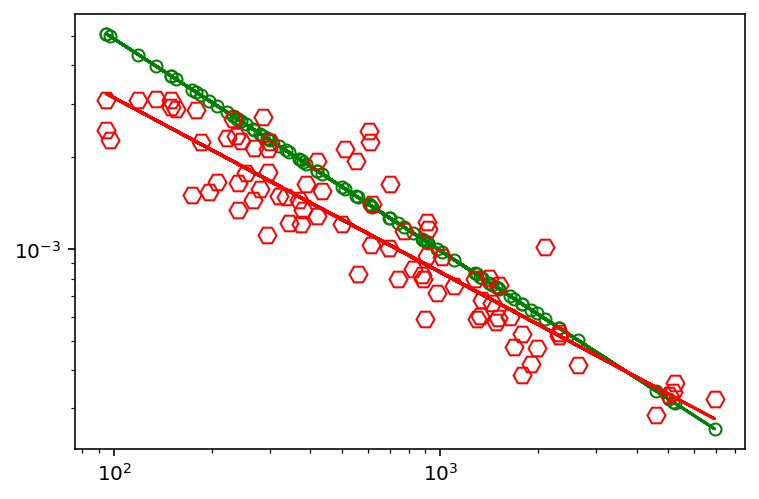

In [19]:
# here prepare the models for Swi/Pce/N
def SWI(POR, PERM):
    return 0.000


def Pce(POR, PERM):  # checked
    return pow(10, -0.572 * log10(PERM / POR) - 1.36)


def NRT(POR, PERM):
    return -0.345054 - 2.01807 * log10(POR)


## Add a trend to test against
plt.semilogx(
    fit_p.perm / fit_p.por,
    (0.12 * pow(sqrt(fit_p.perm / fit_p.por), -1.39)),
    "o-",
    fillstyle="none",
    color="green",
    label="universal",
)
plt.loglog(
    fit_p.perm / fit_p.por,
    fit_p.pce,
    "H",
    ms=9,
    fillstyle="none",
    color="r",
    label="fit Pc result",
)
plt.loglog(
    fit_p.perm / fit_p.por,
    Pce(fit_p.por, fit_p.perm),
    "-",
    ms=9,
    fillstyle="none",
    color="r",
    label="fit Pc result",
)

# The function can be converted to a height function
here we convert the permeability according to the k-phi so the function is "porosity only"

In [20]:
# lin(np.log10(xx), lin_n[0][0],lin_n[0][1])
print(lin_n[0][0])
print(lin_n[0][1])
print(lin_n_por[0][0])
print(lin_n_por[0][1])
# Pce model is logPce=a logk/phi +b
print(lin_bsr[0][0])
print(lin_bsr[0][1])

0.8873829733541598
-0.7854588251445506
-4.738524018898484
2.6029743036606448
-0.5795387228982113
-1.331779274673978


In [21]:
def swthfc(
    x, POR, delta, sct
):  # x is HAFWL in meters delta in g/cm3, sct = iftcos dy/cm
    return np.minimum(
        1,
        np.maximum(
            0,
            0.0936
            + (1 - 0.0936)
            * (
                (0.12 * pow(np.sqrt(perm_function(POR, 5.64, 6.18) / POR), -1.39))
                / (x * delta * 0.098 * (1.0 / (sct)))
            )
            ** (1.0 / (-0.345054 - 2.01807 * log10(POR))),
        ),
    )

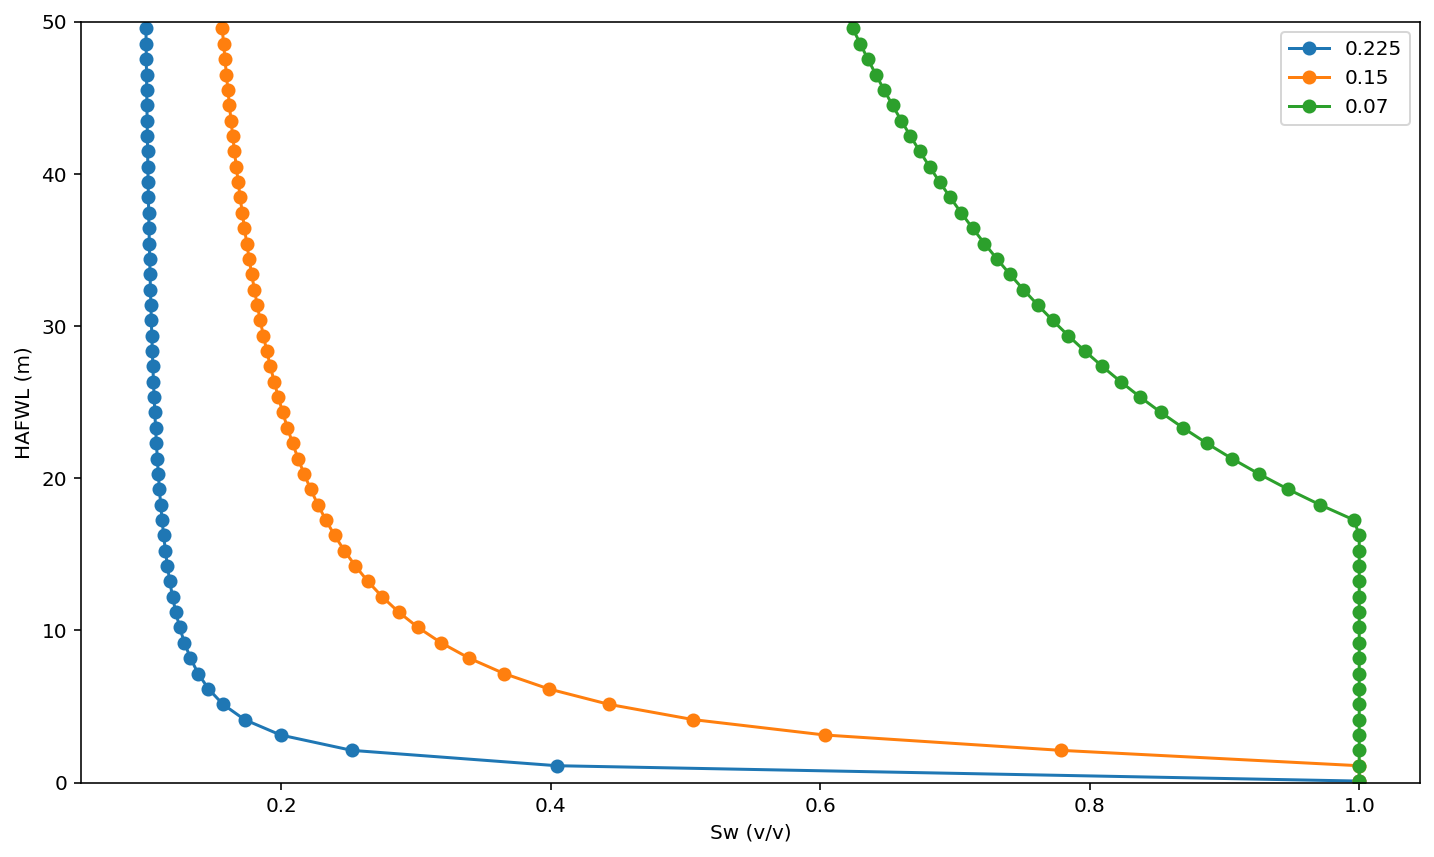

In [22]:
# visualize the function for a number of porosity values (0.225, 0.15 and 0.07 in this case)
# In the same way different Rock types/SHMs can be contrasted
for por in (0.225, 0.15, 0.07):
    plt.plot(swthfc(xvalues, por, 0.5, 26), xvalues, "o-", label=por)
plt.legend()
plt.xlabel("Sw (v/v)")
plt.ylabel("HAFWL (m)")
plt.ylim(0, 50)
plt.gcf().set_size_inches(12, 7)